In [ ]:
!pip install datasets

In [ ]:
import datasets
import pandas as pd
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

from tqdm import tqdm
import pandas as pd
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

In [ ]:
# pegar uma porcentagem do dataset de tal modo que as classes estejam balanceadas
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    dataset = pd.DataFrame(dataset)
    dataset = dataset[['text', 'label']]
    dataset = dataset.groupby("label").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

def selected_categories(row):
    return row["Categoria"] in ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]

In [ ]:
dataset = datasets.load_dataset("told-br")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for told-br contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/told-br
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
Categories = ['Non-toxic', 'Toxic']

In [ ]:
train , validation = train_test_split(dataset['train'].to_pandas(), test_size=0.13, random_state=42) # esse dataset não tem valid
perc_train = 1
perc = 1

train_df = get_balanced_dataset(train, perc_train)
test_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(validation, perc)
train_df['Categories'] = train_df['label'].apply(lambda x: Categories[x])

In [ ]:
test_df['Categories'] = test_df['label'].apply(lambda x: Categories[x])

In [ ]:
# Contagem de labels em cada dataset
count_train = train_df['label'].value_counts()
count_test = test_df['label'].value_counts()
count_valid = valid_df['label'].value_counts()
# Encontrando a menor contagem em cada dataset
min_count_train = count_train.min()
min_count_test = count_test.min()
min_count_valid = count_valid.min()

# Fazendo o resample (downsampling) para o dataset de treino
train_df = pd.concat([
    train_df[train_df['label'] == label].sample(n=min_count_train, random_state=42)
    for label in train_df['label'].unique()
])

# Fazendo o resample (downsampling) para o dataset de teste
test_df = pd.concat([
    test_df[test_df['label'] == label].sample(n=min_count_test, random_state=42)
    for label in test_df['label'].unique()
])

valid_df = pd.concat([
    valid_df[valid_df['label'] == label].sample(n=min_count_valid, random_state=42)
    for label in valid_df['label'].unique()
])


<Axes: title={'center': 'Distribuição das categorias - Treino ToLD-Br'}, xlabel='label'>

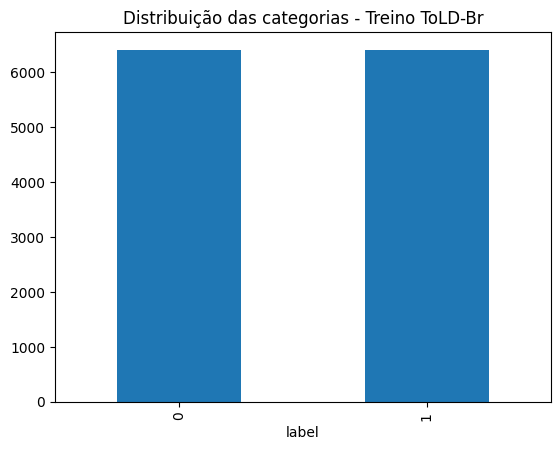

In [ ]:
pd.DataFrame(train_df)['label'].value_counts().plot(kind='bar', title='Distribuição das categorias - Treino ToLD-Br')

In [ ]:
train_df['size'] = train_df['text'].apply(len)
test_df['size'] = test_df['text'].apply(len)
valid_df['size'] = valid_df['text'].apply(len)

In [ ]:
train_df

,text,label,Categories,size
1203,@user mano o pior 茅 que parece mesmo pqp,0,Non-toxic,40
3437,"eu odeio emagrecer por tudo, respirei diferent...",0,Non-toxic,66
4886,rt @user sdds de ir na viva noite e tomar umas...,0,Non-toxic,91
6063,"@user porra, aaa eu tenho simmmm",0,Non-toxic,32
866,to puto pq minha mãe me acordou,0,Non-toxic,31
...,...,...,...,...
11976,meu pai é bem broto 😌,1,Toxic,21
13395,@user tá maluca tu tem mó rabão desgraçada,1,Toxic,42
13430,@user e é o russo de araraquara,1,Toxic,31
13594,"a gente faz as coisas na boa vontade, resolve ...",1,Toxic,113


In [ ]:
# Defining pre-processing parameters
max_len = train_df['size'].max()
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = int(train_df['size'].mean())

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_df['text'])

In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

23304

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(train_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
valid_sequences = tokenizer.texts_to_sequences(valid_df['text'])
valid_padded = pad_sequences(valid_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', train_padded.shape)
print('Shape of testing tensor: ', test_padded.shape)
print('Shape of testing tensor: ', valid_padded.shape)

Shape of training tensor:  (12824, 367)
Shape of testing tensor:  (1944, 367)
Shape of testing tensor:  (1926, 367)


In [ ]:
num_classes = 2

### Dense Model

In [ ]:
# Define parameter
embedding_dim = 16
drop_value = 0.2
n_dense = 24

# Define Dense Model Architecture
dense_model = Sequential()
dense_model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
dense_model.add(GlobalAveragePooling1D())
dense_model.add(Dense(24, activation='relu'))
dense_model.add(Dropout(drop_value))
dense_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 367, 16)           1376      
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 50        
                                                                 
Total params: 1834 (7.16 KB)
Trainable params: 1834 (7.16 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [ ]:
dense_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
model_name = "dense_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.000001)

In [ ]:
num_epochs = 100
history = dense_model.fit(train_padded,
                    train_df['label'],
                    epochs=num_epochs,
                    validation_data=(valid_padded, valid_df['label']),
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction],
                    verbose=2)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.69281, saving model to dense_model.keras
401/401 - 2s - loss: 0.6933 - accuracy: 0.5011 - val_loss: 0.6928 - val_accuracy: 0.5000 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.69281 to 0.69204, saving model to dense_model.keras
401/401 - 1s - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6920 - val_accuracy: 0.5343 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.69204 to 0.68887, saving model to dense_model.keras
401/401 - 1s - loss: 0.6917 - accuracy: 0.5252 - val_loss: 0.6889 - val_accuracy: 0.5395 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.68887 to 0.68124, saving model to dense_model.keras
401/401 - 1s - loss: 0.6862 - accuracy: 0.5568 - val_loss: 0.6812 - val_accuracy: 0.5649 - lr: 0.0010 - 1s/epoch - 3ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.68124 to 0.66613, saving model to dense_model.keras
401/401 - 1s 

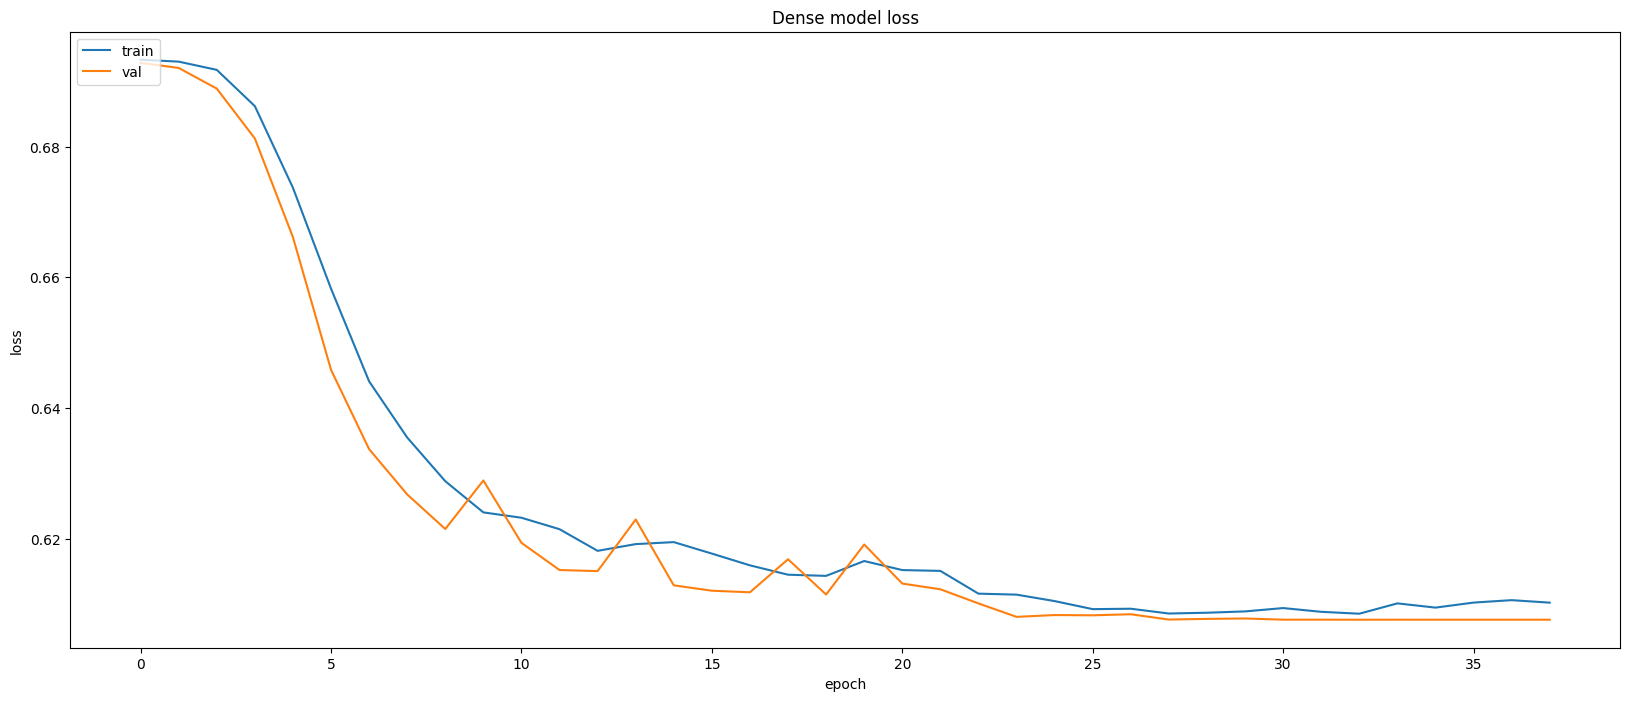

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Dense model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

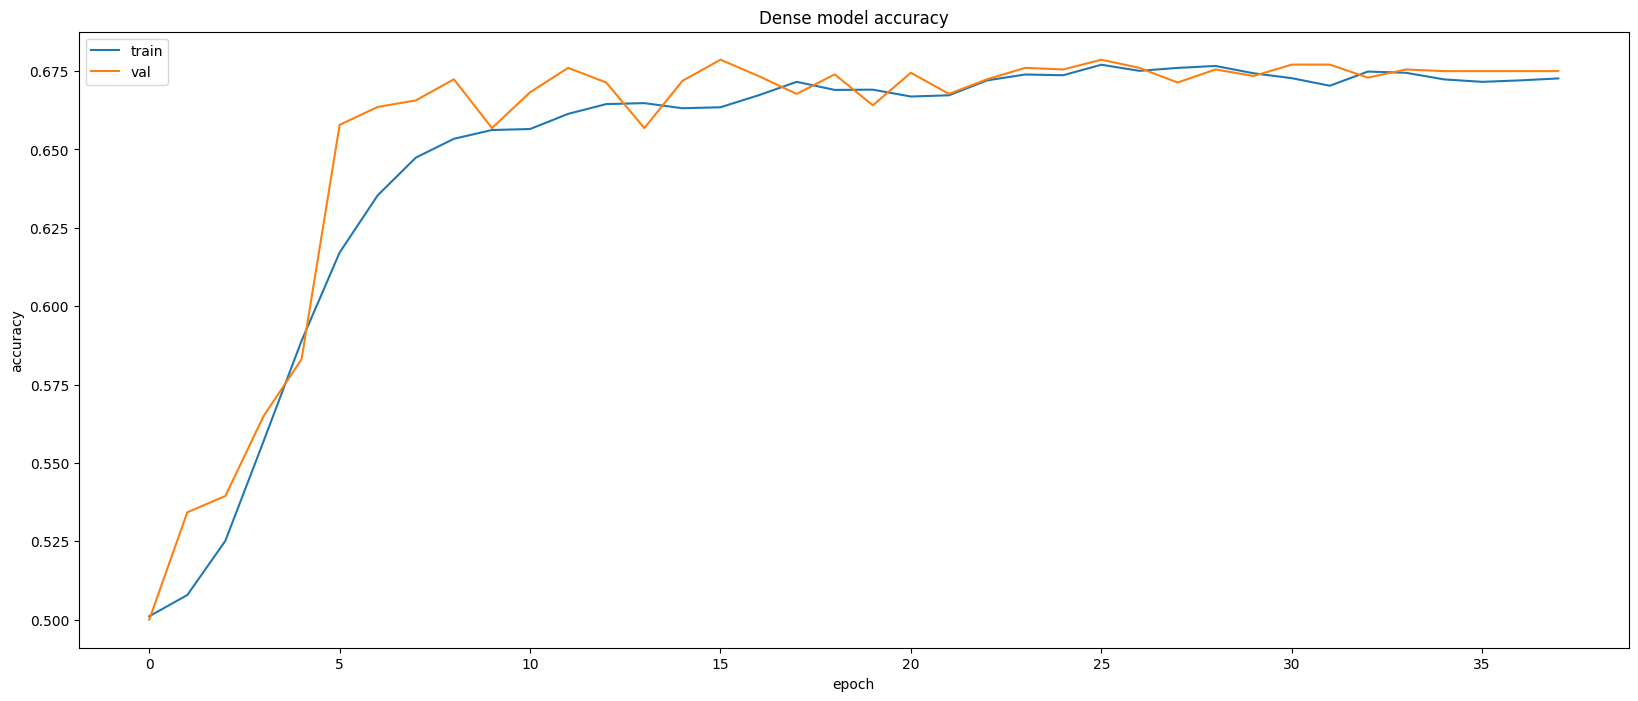

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Dense model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Avaliação do modelo no conjunto de teste
loss, accuracy = dense_model.evaluate(test_padded, test_df['label'])

# Imprimir as métricas
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

61/61 [==============================] - 0s 2ms/step - loss: 0.6163 - accuracy: 0.6692
Loss: 0.6163
Accuracy: 0.6692


In [ ]:
# Obter as previsões do modelo
predictions = dense_model.predict(test_padded)

# Converter as probabilidades em classes preditas (supondo que seja classificação multiclasse)
predicted_classes = predictions.argmax(axis=1)

# Calcular e imprimir outras métricas
print(classification_report(test_df['label'], predicted_classes))

61/61 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.65      0.72      0.69       972
           1       0.69      0.62      0.65       972

    accuracy                           0.67      1944
   macro avg       0.67      0.67      0.67      1944
weighted avg       0.67      0.67      0.67      1944



In [ ]:
test_df

,text,label,Categories,size
1091,ganhamo essa porra e só isso importa #voleinag...,0,Non-toxic,50
898,criança eh tudo de bom né,0,Non-toxic,25
739,rt @user hoje acordei me sentindo a própria ca...,0,Non-toxic,59
140,"@user vou nem falar nada, tu q abandona os pobre",0,Non-toxic,48
1019,@user verde fácil,0,Non-toxic,17
...,...,...,...,...
1234,fodase irmão vai te tomar no cu,1,Toxic,31
1398,meubdeus eu vou infartar caralho\n#voleinaglob...,1,Toxic,71
1988,parece um anjo vai se fuder??? https://t.co/9v...,1,Toxic,54
1563,A serio que vcs estão a dar hate nisto? É a MÃ...,1,Toxic,162


61/61 [==============================] - 0s 2ms/step


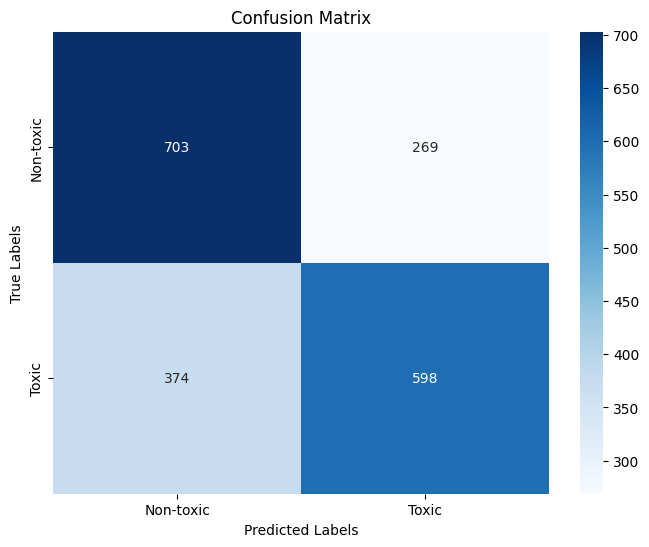

In [ ]:
# Obter as previsões do modelo
predictions = dense_model.predict(test_padded)
predicted_classes = predictions.argmax(axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(test_df['label'], predicted_classes)

# Definir rótulos das classes (opcional)
class_names = test_df['Categories'].unique()  # Substitua pelas suas classes

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()